In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import mlflow
import time
import seaborn as sns

## Séparation des données

In [5]:
new_df = pd.read_csv("utils_features.csv")

In [6]:
import re
new_df = new_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [7]:
new_df.set_index('SK_ID_CURR', inplace=True)

In [8]:
X = new_df.drop(columns='TARGET')
y = new_df['TARGET']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

## Équilibrage des classes

In [10]:
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [11]:

counter_before = Counter(y_train)
counter_after = Counter(y_train_over)
print(counter_before, counter_after)

Counter({0: 197863, 1: 17391}) Counter({0: 197863, 1: 197863})


## Entrainement des modèles
### Réduction des données
En l'état les données sont trop volumineuses pour pouvoir entrainer les modèles. Nous pouvons les réduire en utilisant la méthode sample() d'un dataframe pandas.

In [12]:
to_sample = X_train_over.merge(y_train_over, left_index=True, right_index=True)

In [13]:
to_sample = to_sample.sample(frac=0.2)

In [14]:
X_train = to_sample.drop(columns='TARGET')
y_train = to_sample['TARGET']

### Logistic regression

In [15]:
import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [16]:
random_seed = 42
kfolds = KFold(n_splits=5, shuffle=True, random_state=random_seed)

In [17]:

def tune(objective, study_name):
    study = optuna.create_study(study_name=study_name, direction='maximize')
    
    study.optimize(objective, n_trials=10)
    
    params = study.best_params
    best_score = study.best_value
    return params, best_score

In [18]:
def log_reg_objective(trial):
    _C = trial.suggest_float('C', 0.01, 100)
    
    clf_log = LogisticRegression(C=_C, random_state=random_seed)
    
    score = cross_val_score(clf_log, X_train, y_train, cv=kfolds, scoring='roc_auc').mean()
    return score

In [19]:
mlflow.set_experiment('optimisation hyperparamètre et entrainement des modèles')

<Experiment: artifact_location='file:///C:/Users/matth/Documents/openclassroom/data_scientist/P7/mlruns/747928904526590890', creation_time=1672240642707, experiment_id='747928904526590890', last_update_time=1672240642707, lifecycle_stage='active', name='optimisation hyperparamètre et entrainement des modèles', tags={}>

[I 2023-01-11 12:52:31,502] A new study created in memory with name: log_reg
C:\Users\matth\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\matth\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://

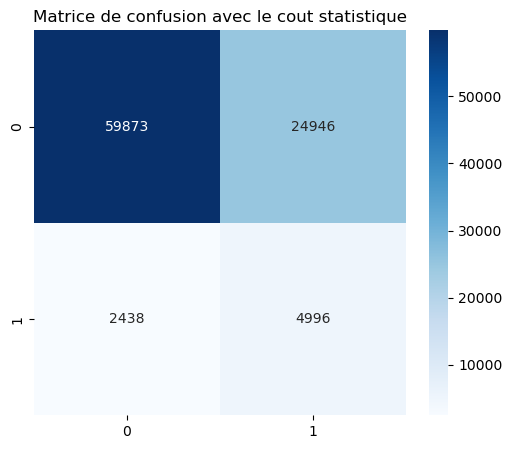

In [23]:
with mlflow.start_run(run_name="Logistic regression"):
    params = {}
    params['MODEL_NAME'] = 'logistic_regression'
    params['TRAIN_SIZE'] = len(X_train)
    
    start = time.time()
    log_params, log_score = tune(log_reg_objective, 'log_reg')
    params['time'] = time.time() - start
    
    params['C'] = log_params['C']
    params['train_roc_auc'] = log_score
    train_roc_auc = log_score
    mlflow.log_metric('train_roc_auc', train_roc_auc) 
    train_roc_auc = log_score
    
    # On entraine le modèle avec les paramètres retournés
    clf_log = LogisticRegression(C=params['C'])
    clf_log.fit(X_train, y_train)
    
    # On calcul le score final du modele avec les données de test
    y_pred = clf_log.predict(X_test)
    params['test_roc_auc'] = roc_auc_score(y_test, y_pred)
    mlflow.log_metric('test_roc_auc',roc_auc_score(y_test, y_pred))
    
    # calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    cm = sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    plt.title("Matrice de confusion avec le cout statistique")
    plt.savefig("confusion_matrix_hors_metier.png")

    mlflow.log_artifact(local_path="confusion_matrix_hors_metier.png")
    mlflow.log_params(params)
    # On sauvegarde le model pour l'utiliser dans le futur sans avoir à l'entrainer de nouveau
    mlflow.sklearn.log_model(clf_log, 'log_reg')

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 10)
    
    
    clf_forest = RandomForestClassifier(max_depth=_max_depth,
                                        n_estimators=_n_estimators,
                                        random_state=random_seed)
    
    score = cross_val_score(clf_forest,
                            X_train,
                            y_train,
                            cv=kfolds,
                            scoring='roc_auc').mean()
    
    return score

In [19]:
with mlflow.start_run(run_name="Random Forest"):
    params = {}
    params['MODEL_NAME'] = 'Random Forest'
    params['TRAIN_SIZE'] = len(X_train)
    
    # Optimisation des hyperparamètres
    start = time.time()
    forest_params, forest_score = tune(randomforest_objective)
    params['time'] = time.time() - start
    
    params['n_estimators'] = forest_params['n_estimators']
    params['max_depth'] = forest_params['max_depth']
    train_roc_auc = forest_score
    mlflow.log_metric('train_roc_auc', train_roc_auc)
    
    # On entraine le modèle avec les paramètres retournés
    clf_forest = RandomForestClassifier(n_estimators=params['n_estimators'],
                                        max_depth=params['max_depth'],
                                        random_state=random_seed)
    clf_forest.fit(X_train, y_train)
    
    # On calcule le score final du modele avec les données test
    y_pred = clf_forest.predict(X_test)
    mlflow.log_metric('test_roc_auc',roc_auc_score(y_test, y_pred))
    mlflow.log_params(params)
    
    # On sauvegarde le modele
    mlflow.sklearn.log_model(clf_forest, 'Random forest')

[I 2022-12-28 16:18:24,948] A new study created in memory with name: log_reg
[I 2022-12-28 16:19:29,564] Trial 0 finished with value: 0.9119124131897799 and parameters: {'n_estimators': 61, 'max_depth': 6}. Best is trial 0 with value: 0.9119124131897799.
[I 2022-12-28 16:21:18,416] Trial 1 finished with value: 0.9464632727402644 and parameters: {'n_estimators': 65, 'max_depth': 10}. Best is trial 1 with value: 0.9464632727402644.
[I 2022-12-28 16:23:04,974] Trial 2 finished with value: 0.9387903948551776 and parameters: {'n_estimators': 70, 'max_depth': 9}. Best is trial 1 with value: 0.9464632727402644.
[I 2022-12-28 16:25:14,302] Trial 3 finished with value: 0.9316418840029149 and parameters: {'n_estimators': 94, 'max_depth': 8}. Best is trial 1 with value: 0.9464632727402644.
[I 2022-12-28 16:30:01,457] Trial 4 finished with value: 0.9471277083622139 and parameters: {'n_estimators': 185, 'max_depth': 10}. Best is trial 4 with value: 0.9471277083622139.
[I 2022-12-28 16:31:46,167] Tr

### XGBOOST

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

def xgboost_objective(trial):
    _n_estimators = trial.suggest_int("n_estimator", 10, 100, 10)
    _max_depth = trial.suggest_int('max_depth', 5, 25, 2)
    #_learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)
    
    
    clf_boost = GradientBoostingClassifier(max_depth=_max_depth,
                                           n_estimators=_n_estimators,
                                           #learning_rate=_learning_rate,
                                           random_state=random_seed)
    
    score = cross_val_score(clf_boost, X_train, y_train, cv=kfolds, scoring='roc_auc').mean()
    
    return score


In [ ]:
mlflow.set_experiment('optimisation cout metier')

In [ ]:
with mlflow.start_run(run_name="xgboost"):
    params = {}
    params['MODEL_NAME'] = 'xgboost'
    params['TRAIN_SIZE'] = len(X_train)
    
    start = time.time()
    xgboost_params, xgboost_score = tune(xgboost_objective, study_name='xgboost')
    params['time'] = time.time() - start
    
    params['n_estimators'] = xgboost_params['n_estimators']
    params['max_depth'] = xgboost_params['max_depth']
    #params['learning_rate'] = xgboost_params['learning_rate']
    train_roc_auc = xgboost_score
    mlflow.log_metric('train_roc_auc', train_roc_auc)
    
    # On entraine le modèle avec les paramètres retournés
    clf_boost = GradientBoostingClassifier(n_estimators=params['n_estimators'],
                                           max_depth=params['max_depth'],
                                           #learning_rate=params['learning_rate'],
                                           random_state=random_seed)
    clf_boost.fit(X_train, y_train)
    
    # on calcule le score final
    y_pred = clf_boost.predict(X_test)
    mlflow.log_metric('test_roc_auc', roc_auc_score(y_test, y_pred))
     
    mlflow.log_params(params)
    
    # On sauvegarde le modèle
    mlflow.sklearn.log_model(clf_boost, 'XGBOOST')

[I 2023-01-04 12:03:18,623] A new study created in memory with name: xgboost
[I 2023-01-04 12:58:48,522] Trial 0 finished with value: 0.9780936735321244 and parameters: {'n_estimator': 100, 'max_depth': 11}. Best is trial 0 with value: 0.9780936735321244.
[I 2023-01-04 13:43:31,515] Trial 1 finished with value: 0.9783889462472363 and parameters: {'n_estimator': 70, 'max_depth': 13}. Best is trial 1 with value: 0.9783889462472363.
[I 2023-01-04 13:45:59,678] Trial 2 finished with value: 0.9342093088373022 and parameters: {'n_estimator': 10, 'max_depth': 5}. Best is trial 1 with value: 0.9783889462472363.
[I 2023-01-04 13:53:09,011] Trial 3 finished with value: 0.9631364863661851 and parameters: {'n_estimator': 30, 'max_depth': 5}. Best is trial 1 with value: 0.9783889462472363.
[I 2023-01-04 14:32:50,833] Trial 4 finished with value: 0.9774930891104046 and parameters: {'n_estimator': 70, 'max_depth': 11}. Best is trial 1 with value: 0.9783889462472363.
[I 2023-01-04 14:49:10,003] Trial 

### LightGBM

In [15]:
from lightgbm import LGBMClassifier

def lightgbm_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    
    
    clf_lightgbm = LGBMClassifier(
                                  num_leaves=_num_leaves,
                                  max_depth=_max_depth,
                                  learning_rate=_learning_rate,
                                  n_estimators=_n_estimators,
                                  min_child_weight=_min_child_weight,
                                  subsample=_subsample,
                                  reg_alpha=_reg_alpha,
                                  reg_lambda=_reg_lambda,
                                  random_state=random_seed,
    )
    
    
    score = cross_val_score(clf_lightgbm, X_train, y_train, cv=kfolds, scoring='roc_auc').mean()
    
    return score
    
    

In [18]:
with mlflow.start_run(run_name='light gbm'):
    params = {}
    params['MODEL_NAME'] = 'light gbm'
    params['TRAIN_SIZE'] = len(X_train)
    
    start = time.time()
    lgbmt_params, lgbm_score = tune(lightgbm_objective, study_name='lightgbm')
    params['time'] = time.time() - start
    
    params['n_estimators'] = lgbmt_params['n_estimators']
    params['max_depth'] = lgbmt_params['max_depth']
    params['learning_rate'] = lgbmt_params['learning_rate']
    params['num leaves'] = lgbmt_params['num_leaves']
    params['min child weight'] = lgbmt_params['min_child_weight']
    params['reg alpha'] = lgbmt_params['reg_alpha']
    params['reg lambda'] = lgbmt_params['reg_lambda']
    params['subsample'] = lgbmt_params['subsample']
    mlflow.log_metric('train_roc_auc', lgbm_score)
    
    # On entraine le modèle avec les paramètres retournés
    clf_lgbm = LGBMClassifier(n_estimators=params['n_estimators'],
                              max_depth=params['max_depth'],
                              learning_rate=params['learning_rate'],
                              num_leaves=params['num leaves'],
                              min_child_weight=params['min child weight'],
                              reg_alpha=params['reg alpha'],
                              reg_lambda=params['reg lambda'],
                              subsample=params['subsample'],
                              random_state=random_seed)
    clf_lgbm.fit(X_train, y_train)
    
    # On calcule le score final
    y_pred = clf_lgbm.predict(X_test)
    mlflow.log_metric('test_roc_auc', roc_auc_score(y_test, y_pred))
    
    mlflow.log_params(params)
    
    # On sauvegarde le modèle
    mlflow.sklearn.log_model(clf_lgbm, 'LGBM')

[I 2023-01-04 16:56:17,151] A new study created in memory with name: lightgbm
[I 2023-01-04 16:58:20,929] Trial 0 finished with value: 0.9772113205102875 and parameters: {'num_leaves': 65, 'max_depth': 5, 'learning_rate': 0.070429067290123, 'n_estimators': 1948, 'min_child_weight': 5.109067046621498, 'reg_alpha': 6.372934911029781, 'reg_lambda': 7.917585220303045, 'subsample': 0.2719627749838453}. Best is trial 0 with value: 0.9772113205102875.
[I 2023-01-04 16:58:33,702] Trial 1 finished with value: 0.9770049119107733 and parameters: {'num_leaves': 86, 'max_depth': 3, 'learning_rate': 0.2840977927132267, 'n_estimators': 262, 'min_child_weight': 1.1063609272991082, 'reg_alpha': 2.2975188923242045, 'reg_lambda': 5.556815899726475, 'subsample': 0.031126658685631817}. Best is trial 0 with value: 0.9772113205102875.
[I 2023-01-04 16:59:01,477] Trial 2 finished with value: 0.975200691063123 and parameters: {'num_leaves': 66, 'max_depth': 14, 'learning_rate': 0.5419495407710921, 'n_estimator